In [2]:
from gekko import GEKKO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

## Simulation Model

In [4]:
m = GEKKO(remote=False)
nt = 101

#---- Constants ----#

Hf_a = m.Const(-2.4700e5) # kJ/kmol
Hf_b = m.Const(-47500)
Hf_c = m.Const(-74520)
Hf_d = m.Const(-1.1053e5)
Hf_e = m.Const(52510)

A_1 = m.Const(8.2e14)
Ea_1 = m.Const(2.845e5) # J/mol

A_2 = m.Const(1.7e17)
Ea_2 = m.Const(3.259e5) # J/mol

Dt = 1 # m

P = m.Const(101325)
R1 = 8.314
R2 = 8314

#---- Parameters ----#
U = m.Param(6800/.128)

T_0 = 700+273.15
Ta = m.Param(124 + 273.15)
Fa_0 = 100
L_f = 5

# Inlet Conditions
L = np.linspace(0, L_f, nt)
Vr_f = np.pi*(Dt/2)**2*L[-1]
m.time = np.linspace(0, Vr_f, nt)

V0 = Fa_0*R2*T_0/P

Fb_0 = 0
Fc_0 = 0
Fd_0 = 0
Fe_0 = 0
Ft_0 = Fa_0

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

#---- Variables ----#

Fa = m.Var(value=Fa_0, lb=0, ub=200, name='Fa')
Fb = m.CV(value=Fb_0, lb=0, ub=200, name='Fb')
Fc = m.Var(value=Fc_0, lb=0, ub=200, name='Fc')
Fd = m.Var(value=Fd_0, lb=0, ub=200, name='Fd')
Fe = m.Var(value=Fe_0, lb=0, ub=200, name='Fe')
T = m.CV(value=T_0, lb=600+273.15, ub=800+273.15, name='T')

Fb.STATUS = 0
Fb.COST = -50
Fb.TIER = 50
T.STATUS = 0

#---- Intermediates ----#

Ft = m.Intermediate(Fa + Fb + Fc + Fd + Fe)
ya = m.Intermediate(Fa/Ft)
yb = m.Intermediate(Fb/Ft)
yc = m.Intermediate(Fc/Ft)
yd = m.Intermediate(Fd/Ft)
ye = m.Intermediate(Fe/Ft)

A, B, C, D, E, F, G = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
Cp_a = m.Intermediate(A + B*(((C/T)**2*m.exp(C/T))/(m.exp(C/T) -1)**2) + D*(((E/T)**2*m.exp(E/T))/(m.exp(E/T) -1)**2) + F*(((G/T)**2*m.exp(G/T))/(m.exp(G/T) -1)**2))
A, B, C, D, E = [36940, 68650, 1490, 45240, 640]
Cp_b = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [33298, 79933, 2086.9, 41602, 991.96]
Cp_c = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [29108, 8773, 3085.1, 8455.3, 1538.2]
Cp_d = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [33380, 94790, 1596, 55100, 740.8]
Cp_e = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
A, B, C, D, E = [33363, 26790, 2610.5, 8896, 1169]
Cp_f = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)

V = m.Intermediate(V0*(T/T_0)*(Ft/Ft_0))

Ca = m.Intermediate(Fa/V)
Cb = m.Intermediate(Fb/V)
Cc = m.Intermediate(Fc/V)
Cd = m.Intermediate(Fd/V)
Ce = m.Intermediate(Fe/V)

#-- Kinetics --#

k_1 = m.Intermediate(A_1*m.exp(-Ea_1/(R1*T)))
k_2 = m.Intermediate(A_2*m.exp(-Ea_2/(R1*T)))

r_1 = m.Intermediate(k_1*Ca*3600)
r_2 = m.Intermediate(k_2*Cb*3600)

#-- Heat Transfer --#

Q = m.Intermediate(U*(T - Ta))

#---- Thermodynamics ----#

ΔHr_1 = m.Intermediate((   Hf_c + Hf_b - Hf_a) + (   Cp_c + Cp_b - Cp_a)*(T - 298.15))
ΔHr_2 = m.Intermediate((.5*Hf_e + Hf_d - Hf_b) + (.5*Cp_e + Cp_d - Cp_b)*(T - 298.15))

#---- Equations ----#

m.Equation(Fa.dt() == -r_1)
m.Equation(Fb.dt() ==  r_1 - r_2)
m.Equation(Fc.dt() ==  r_1)
m.Equation(Fd.dt() ==  r_2)
m.Equation(Fe.dt() == .5*r_2)
m.Equation(T.dt() ==        (Q*4 - r_1*ΔHr_1 - r_2*ΔHr_2)/          \
                        (Fa*Cp_a + Fb*Cp_b + Fc*Cp_c + Fd*Cp_d + Fe*Cp_e))

m.options.IMODE = 4
m.options.SOLVER = 3
m.options.NODES = 3

#m.open_folder()
m.solve(disp=False)

## Plot Model

Coolant Temperature: 397.15 K
Volume of Reactor: 3.927 m3
Length of Reactor: 5.000 m
Overall Heat Transfer Coefficient: 53125.0 kJ/m2-K
Composition of Ketene: 0.10368685848


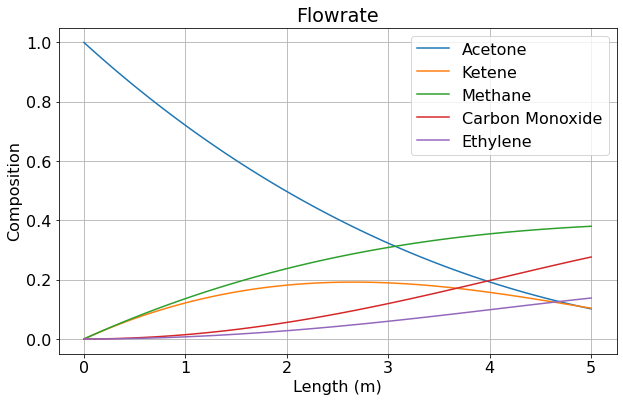

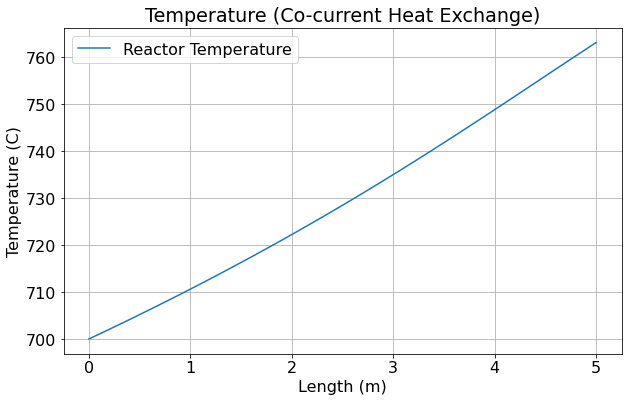

In [8]:
L = np.linspace(0, L_f, nt)
plotsize=(10,6)
fontsize=16

print(f'Coolant Temperature: {float(Ta.value[-1])} K')
print(f'Volume of Reactor: {Vr_f:.3f} m3')
print(f'Length of Reactor: {L_f:.3f} m')
print(f'Overall Heat Transfer Coefficient: {float(U.value[-1])} kJ/m2-K')
print(f'Composition of Ketene: {float(yb.value[-1])}')

plt.figure(1, figsize=plotsize)
plt.rc('font', size=fontsize)
plt.plot(L, ya.value, label='Acetone')
plt.plot(L, yb.value, label='Ketene')
plt.plot(L, yc.value, label='Methane')
plt.plot(L, yd.value, label='Carbon Monoxide')
plt.plot(L, ye.value, label='Ethylene')
plt.ylabel('Composition')
plt.title('Flowrate')
plt.xlabel('Length (m)')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(2, figsize=plotsize)
plt.rc('font', size=fontsize)
plt.plot(L,np.array([T.value])[0,:]-273.15, label='Reactor Temperature')
#plt.plot(L,np.array([Ta.value])[0,:]-273.15, label='Jacket Temperature')
plt.xlabel('Length (m)')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')
plt.title('Temperature (Co-current Heat Exchange)')
plt.grid()
plt.show()


## Estimation

In this portion of the code, we will see how both volumetric flow rate and jacket mass flow rate affect the flow rate of ketene.

### ODEINT Model

In [53]:
def PFR(y, Vr, U, Ta, D):
    Fa, Fb, Fc, Fd, Fe, T = y
    
    FT = Fa + Fb + Fc + Fd + Fe
    ya, yb, yc, yd, ye = Fa/FT, Fb/FT, Fc/FT, Fd/FT, Fe/FT
    
    v̇ = v̇0*FT/FT0*T/T_0
    
    Ca = Fa/v̇
    Cb = Fb/v̇
    Cc = Fc/v̇
    Cd = Fd/v̇
    Ce = Fe/v̇
    
    #---- Constants ----#
    
    
    def Cps(T, A, B, C, D, E, F, G):
        return A + B*(((C/T)**2*np.exp(C/T))/(np.exp(C/T) -1)**2) + D*(((E/T)**2*np.exp(E/T))/(np.exp(E/T) -1)**2) + F*(((G/T)**2*np.exp(G/T))/(np.exp(G/T) -1)**2)
    
    def Cp(T, A, B, C, D, E):
        return A + B*(C/T/(np.sinh(C/T)))**2 + D*(E/T/(np.cosh(E/T)))**2
    
    coeff_a = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
    coeff_b = [36940, 68650, 1490, 45240, 640]
    coeff_c = [33298, 79933, 2086.9, 41602, 991.96]
    coeff_d = [29108, 8773, 3085.1, 8455.3, 1538.2]
    coeff_e = [33380, 94790, 1596, 55100, 740.8]
    
    Cpa = Cps(T, *coeff_a)
    Cpb = Cp(T, *coeff_b)
    Cpc = Cp(T, *coeff_c)
    Cpd = Cp(T, *coeff_d)
    Cpe = Cp(T, *coeff_e)
    Cpf = 40.911 # kJ/kmol
    
    Cp_t = ya*Cpa + yb*Cpb + yc*Cpc + yd*Cpd + ye*Cpe
    
    
    
    #---- Kinetics ----#
    
    def k(A, Ea, T):
        R = 8.314 # J/mole-K
        return A*np.exp(-Ea/(R*T))
    
    A_1 = 8.2e14
    Ea_1 = 2.845e5 # J/mol
    k_1 = k(A_1, Ea_1, T)
    
    A_2 = 1.7e17
    Ea_2 = 3.259e5 # J/mol
    k_2 = k(A_2, Ea_2, T)
    
    r_1 = k_1*Ca*3600
    r_2 = k_2*Cb*3600
    
    Q = U*(T - Ta)
    
    #---- Thermodynamics ----#
    
    Hr_a = -2.4700e5 # kJ/kmol
    Hr_b = -47500
    Hr_c = -74520
    Hr_d = -1.1053e5
    Hr_e = 52510
    
    ΔHr_1 = (Hr_c + Hr_b - Hr_a) + (Cpc + Cpb -Cpa)*(T - 298.15)
    ΔHr_2 = (.5*Hr_e + Hr_d - Hr_b) + (.5*Cpe + Cpd -Cpb)*(T - 298.15)
    
    #---- Equations ----#
    
    dFadVr =   -r_1
    dFbdVr =    r_1 - r_2
    dFcdVr =    r_1
    dFddVr =    r_2
    dFedVr = .5*r_2
    dTdVr = (Q*4/D - r_1*ΔHr_1 - r_2*ΔHr_2)/\
            (Fa*Cpa + Fb*Cpb + Fc*Cpc + Fd*Cpd + Fe*Cpe)
    
    
    return dFadVr, dFbdVr, dFcdVr, dFddVr, dFedVr, dTdVr

### Analysis

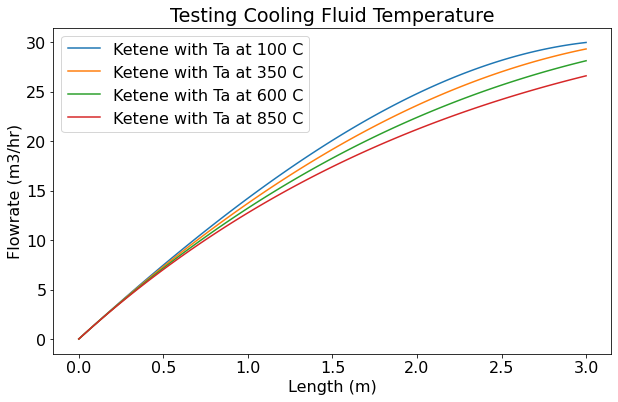

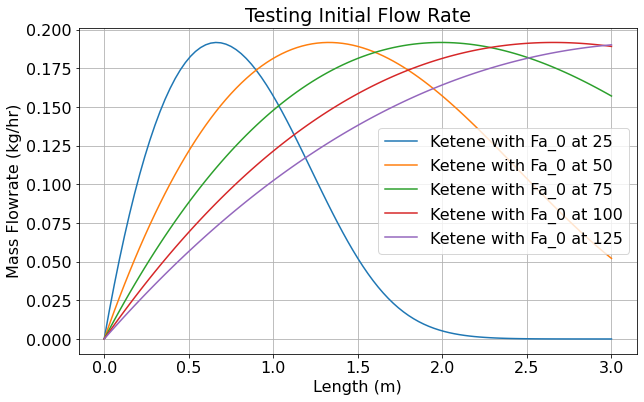

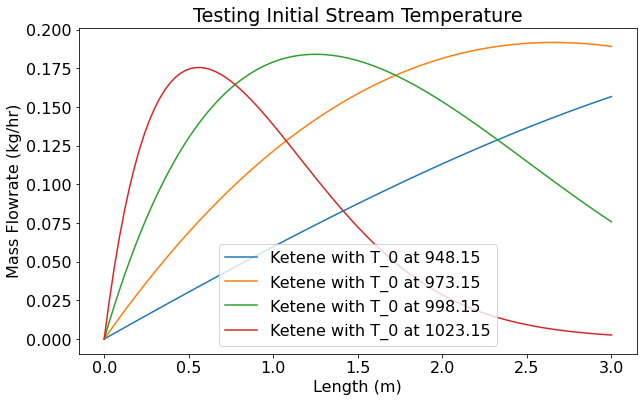

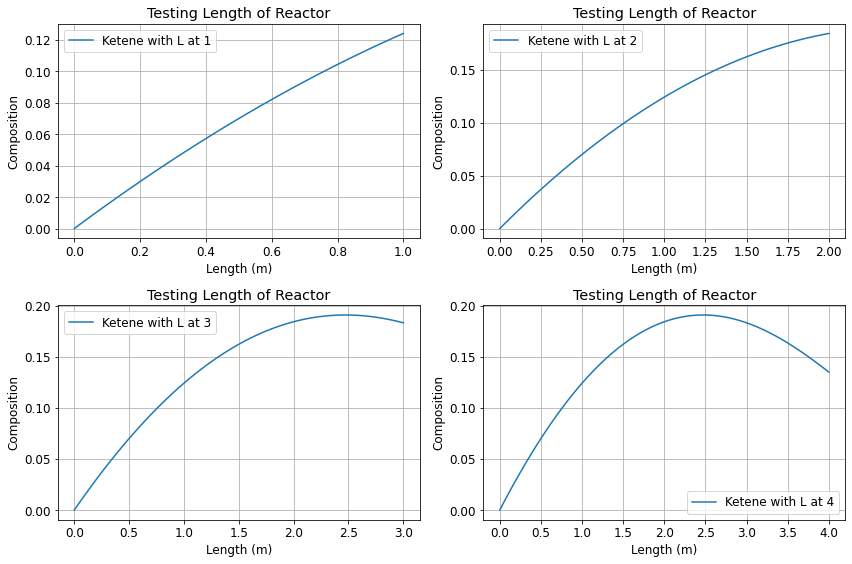

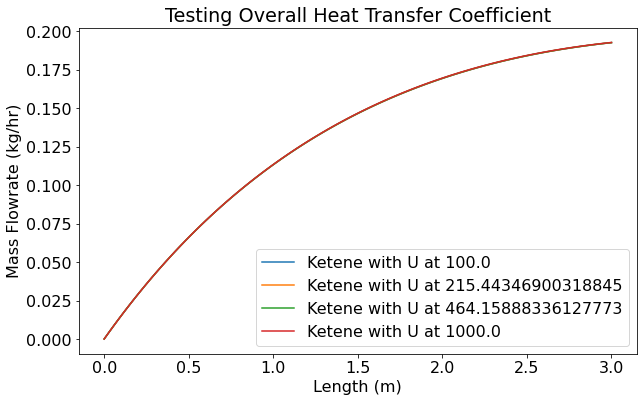

In [54]:
#---- Constants ----#
P = 101325 # Pa
R = 8314 # J/kmol-K
D = 1 # m

#---- Parameters ----#
T_0 = 700 + 273.15
Fa_0 = 100 # kmol/hr
L_f = 3
U = 6800/.128 # kJ/K-h
Ta = 124 + 273.15
ṁ_f = 1821 # kg/hr

#---- Intermediates ----#
v̇0 = Fa_0*R*T_0/P
FT0 = Fa_0
L = np.linspace(0, L_f, 101)
Vr_f = np.pi*(D/2)**2*L[-1]
Vr = np.linspace(0, Vr_f, 101)


y0 = [Fa_0, 0, 0, 0, 0, T_0]

plotsize=(10,6)
plt.figure(1, figsize=plotsize)
for Ta in range(100, 1001, 250):
    
    initials = [Fa_0, 0, 0, 0, 0, 700+273.15]
    Vr = np.linspace(0, 2.356, 101)
    L = np.linspace(0, 3, 101)


    Fa, Fb, Fc, Fd, Fe, T = odeint(PFR, y0, Vr, args=(U, Ta+273.15, D)).T

    fontsize=16
    plt.rc('font', size=fontsize)
    plt.plot(L, Fb, label=f'Ketene with Ta at {Ta} C')
    plt.ylabel('Flowrate (m3/hr)')
    plt.title('Testing Cooling Fluid Temperature')
    plt.xlabel('Length (m)')
    plt.legend(loc='best')
    plt.grid()
plt.show()

U = 6800/.128 # kJ/K-h
Ta = 124 + 273.15
T_0 = 700 + 273.15
Fa_0 = 100 # kmol/hr

plt.figure(2, figsize=plotsize)
for Fa_0 in range(25, 126, 25):
    
    initials = [Fa_0, 0, 0, 0, 0, 700+273.15]
    Vr = np.linspace(0, 2.356, 101)
    L = np.linspace(0, 3, 101)


    Fa, Fb, Fc, Fd, Fe, T, = odeint(PFR, initials, Vr, args=(U, Ta, D)).T
    
    Ft = Fa + Fb + Fc + Fd + Fe
    yb = Fb/Ft

    
    fontsize=16
    plt.rc('font', size=fontsize)
    plt.plot(L, yb, label=f'Ketene with Fa_0 at {Fa_0}')
    plt.ylabel('Mass Flowrate (kg/hr)')
    plt.title('Testing Initial Flow Rate')
    plt.xlabel('Length (m)')
    plt.legend(loc='best')
    plt.grid()
plt.show()

U = 6800/.128 # kJ/K-h
Ta = 124 + 273.15
T_0 = 700 + 273.15
Fa_0 = 100 # kmol/hr

plt.figure(3, figsize=plotsize)
for T_0 in range(675, 751, 25):
    T_0 += 273.15
    
    initials = [Fa_0, 0, 0, 0, 0, T_0]
    Vr = np.linspace(0, 2.356, 101)
    L = np.linspace(0, 3, 101)


    Fa, Fb, Fc, Fd, Fe, T, = odeint(PFR, initials, Vr, args=(U, Ta, D)).T
    
    Ft = Fa + Fb + Fc + Fd + Fe
    yb = Fb/Ft

    
    fontsize=16
    plt.rc('font', size=fontsize)
    plt.plot(L, yb, label=f'Ketene with T_0 at {T_0}')
    plt.ylabel('Mass Flowrate (kg/hr)')
    plt.title('Testing Initial Stream Temperature')
    plt.xlabel('Length (m)')
    plt.legend(loc='best')
    plt.grid()
plt.show()

U = 8800/.128 # kJ/K-h
Ta = 124 + 273.15
T_0 = 700 + 273.15
Fa_0 = 100 # kmol/hr
U_range = np.logspace(2, 3, 4)

plt.figure(4, figsize=(12,8))
plt.rc('font', size=12)


for L_f in range(1, 5, 1):
    initials = [Fa_0, 0, 0, 0, 0, T_0]
    
    L = np.linspace(0, L_f, 101)
    Vr_f = np.pi*(D/2)**2*L[-1]
    Vr = np.linspace(0, Vr_f, 101)

    Fa, Fb, Fc, Fd, Fe, T, = odeint(PFR, initials, Vr, args=(U, Ta, D)).T

    Ft = Fa + Fb + Fc + Fd + Fe
    yb = Fb/Ft


    fontsize=16
    plt.subplot(2, 2, L_f)
    plt.plot(L, yb, label=f'Ketene with L at {L_f}')
    plt.ylabel('Composition')
    plt.title('Testing Length of Reactor')
    plt.xlabel('Length (m)')
    plt.legend(loc='best')
    plt.grid()
plt.tight_layout()
plt.show()

plt.figure(5, figsize=plotsize)
for U in U_range:
    initials = [Fa_0, 0, 0, 0, 0, T_0]
    Vr = np.linspace(0, 2.356, 101)
    L = np.linspace(0, 3, 101)

    Fa, Fb, Fc, Fd, Fe, T, = odeint(PFR, initials, Vr, args=(U, Ta, D)).T

    Ft = Fa + Fb + Fc + Fd + Fe
    yb = Fb/Ft


    fontsize=16
    plt.rc('font', size=fontsize)
    plt.plot(L, yb, label=f'Ketene with U at {U}')
    plt.ylabel('Mass Flowrate (kg/hr)')
    plt.title('Testing Overall Heat Transfer Coefficient')
    plt.xlabel('Length (m)')
    plt.legend(loc='best')
    plt.grid()
plt.show()


         


## Optimization
### Maximize flowrate of Ketene by adjusting the fixed values of volumetric flow rate and jacket mass flow rate

In [11]:
def run_model(Ta_lb, U_ub):

    m = GEKKO(remote=False)
    #---- Constants ----#
    nt = 151 # number of steps

    # Heat of Formation
    Hf_a = m.Const(-2.4700e5) # kJ/kmol
    Hf_b = m.Const(-47500)
    Hf_c = m.Const(-74520)
    Hf_d = m.Const(-1.1053e5)
    Hf_e = m.Const(52510)

    # Kinetic Constants
    A_1 = m.Const(8.2e14)
    Ea_1 = m.Const(2.845e5) # J/mol

    A_2 = m.Const(1.7e17)
    Ea_2 = m.Const(3.259e5) # J/mol

    # Tube Diameter
    Dt = m.Const(1) # m

    # Pressure and Gas Constants
    P = m.Const(101325) # Pa
    R1 = m.Const(8.314) # J/mol-K
    R2 = m.Const(8314) # J/kmol-K

    #---- Parameters ----#

    Vr_f = m.FV(2.356, lb=2, ub=5, name='Vr_f')                                   # Volume of Reactor (m)

    Ta = m.FV(124 + 273.15, lb = Ta_lb + 273.15, ub=140 + 273.15, name='Ta') # Coolant Temperature (K)
    U = m.FV(6800/.128, lb=1000, ub=U_ub, name='U')                        # Overall Heat Transfer Coefficient (kJ/m2-K)

    m.time = np.linspace(0, Vr_f.value, nt)

    # Setup for final value optmization
    p = np.zeros(nt)
    p[-1] = 1.0
    final = m.Param(value=p)

    #---- Parameter Tuning ----#

    # Fixed Values
    Vr_f.STATUS = 1 # Optimize Value

    # Manipulated Values
    Ta.STATUS = 1 # Don't Optmiize
    U.STATUS = 1


    #---- Variables ----#
    Fa_0 = m.FV(100, lb=80, ub=120)
    T_0 = m.FV(700, lb=675, ub=725)
    Fa_0.STATUS = 0
    T_0.STATUS = 0

    Fa = m.CV(value=Fa_0, lb=0, ub=100, name='Fa', fixed_initial=True) # Flow Rate for species i (kmol/hr)
    Fb = m.CV(value=0, name='Fb')
    Fc = m.SV(value=0, lb=0, ub=60, name='Fc')
    Fd = m.SV(value=0, lb=0, ub=30, name='Fd')
    Fe = m.SV(value=0, lb=0, ub=30, name='Fe')
    T = m.CV(value=T_0, lb=700+273.15, ub=800+273.15, name='T', fixed_initial=True) # Temperature of Reactor

    Fa.STATUS = 1
    Fa.TIER = 1
    Fa.COST = 1
    Fb.STATUS = 0
    Fb.COST = -1e8
    Fb.TIER = 1
    T.STATUS = 1
    T.COST = 1

    # m.free_initial(Fa)
    # m.free_initial(T)


    #---- Intermediates ----#

    Ft_0 = m.Intermediate(Fa_0, name='Ft_0') # Total Initial Molar Flowrate
    Ft = m.Intermediate(Fa + Fb + Fc + Fd + Fe, name='Ft') # Total Molar Flowrate

    V0 = m.Intermediate(Fa_0*R2*T_0/P, name='V0') # Initial Volumetric Flowrate
    V = m.Intermediate(V0*(T/T_0)*(Ft/Ft_0), name='V') # Voluemtric Flowrate

    Ca = m.Intermediate(Fa/V, name='Ca') # Concentration for Species i (kmol/m3)
    Cb = m.Intermediate(Fb/V, name='Cb')

    ya = m.Intermediate(Fa/Ft, name='ya')
    yb = m.Intermediate(Fb/Ft, name='yb') # Mole Fraction of Ketene
    yc = m.Intermediate(Fc/Ft, name='yc')
    yd = m.Intermediate(Fd/Ft, name='yd')
    ye = m.Intermediate(Fe/Ft, name='ye')

    # Heat Capacity (kJ/kmol-K)

    A, B, C, D, E, F, G = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
    Cp_a = m.Intermediate(A + B*(((C/T)**2*m.exp(C/T))/(m.exp(C/T) -1)**2) + D*(((E/T)**2*m.exp(E/T))/(m.exp(E/T) -1)**2) + F*(((G/T)**2*m.exp(G/T))/(m.exp(G/T) -1)**2))
    A, B, C, D, E = [36940, 68650, 1490, 45240, 640]
    Cp_b = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
    A, B, C, D, E = [33298, 79933, 2086.9, 41602, 991.96]
    Cp_c = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
    A, B, C, D, E = [29108, 8773, 3085.1, 8455.3, 1538.2]
    Cp_d = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
    A, B, C, D, E = [33380, 94790, 1596, 55100, 740.8]
    Cp_e = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)
    A, B, C, D, E = [33363, 26790, 2610.5, 8896, 1169]
    Cp_f = m.Intermediate(A + B*(C/T/(m.sinh(C/T)))**2 + D*(E/T/(m.cosh(E/T)))**2)

    # Kinetics

    k_1 = m.Intermediate(A_1*m.exp(-Ea_1/(R1*T))*3600, name='k_1') # Rate Constant for rxn i (1/hr)
    k_2 = m.Intermediate(A_2*m.exp(-Ea_2/(R1*T))*3600, name='k_2')

    r_1 = m.Intermediate(k_1*Ca, name='r_1') # Rate for Reaction i (kmol/m3-hr)
    r_2 = m.Intermediate(k_2*Cb, name='r_2')

    # Heat Transfer 

    Q = m.Intermediate(U*(T - Ta), name='Q') # Heat Flux per area (kJ/m2-hr)
    Qv = m.Intermediate(Q*4/Dt, name='Qv') # Heat Flux per volume (kJ/m3-hr)

    # Thermodynamics 

    ΔHr_1 = m.Intermediate((   Hf_c + Hf_b - Hf_a) + (   Cp_c + Cp_b - Cp_a)*(T - 298.15), name='Hr_1') # Heat of Reaction (kJ/kmol)
    ΔHr_2 = m.Intermediate((.5*Hf_e + Hf_d - Hf_b) + (.5*Cp_e + Cp_d - Cp_b)*(T - 298.15), name='Hr_2')

    #---- Equations ----#

    # Species Balance
    m.Equation(Fa.dt() == -r_1)
    m.Equation(Fb.dt() ==  r_1 - r_2)
    m.Equation(Fc.dt() ==  r_1)
    m.Equation(Fd.dt() ==        r_2)
    m.Equation(Fe.dt() ==     .5*r_2)

    # Energy Balance
    m.Equation(T.dt() ==        (Qv- r_1*ΔHr_1 - r_2*ΔHr_2)/          \
                            (Fa*Cp_a + Fb*Cp_b + Fc*Cp_c + Fd*Cp_d + Fe*Cp_e))

    # Objective Function
    m.Obj(yb*final - .2)

    # Solver Options

    m.options.IMODE = 6 # Dynamic Optimization
    m.options.SOLVER = 3 # IPOPT
    m.options.NODES = 3 # Number of Nodes
    m.options.MAX_ITER = 200
    m.options.CV_TYPE = 1

    #m.open_folder()
    m.solve(disp=False)
    
    L_f = Vr_f.value[-1]/(np.pi*Dt.value**2/4)
    L = np.linspace(0, L_f, nt)

    plotsize=(10,6)
    fontsize=16

    print(f'Optimized Coolant Temperature: {Ta.value[0]-273.15:.3f} C')
    print(f'Optimized Volume of Reactor: {Vr_f.value[-1]:.3f} m3')
    print(f'Optimized Length of Reactor: {L_f:.3f} m')
    print(f'Optimized Overall Heat Transfer Coefficient: {float(U.value[-1]):.3f} kJ/m2-K')
    print(f'Maximized Composition of Ketene: {yb.value[-1]}')

    plt.figure(1, figsize=plotsize)
    plt.rc('font', size=fontsize)
    plt.plot(L, ya.value, label='Acetone')
    plt.plot(L, yb.value, label='Ketene')
    plt.plot(L, yc.value, label='Methane')
    plt.plot(L, yd.value, label='Carbon Monoxide')
    plt.plot(L, ye.value, label='Ethylene')
    plt.ylabel('F (kmol/hr)')
    plt.title('Composition')
    plt.xlabel('V (m3)')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    plt.figure(2, figsize=plotsize)
    plt.rc('font', size=fontsize)
    plt.plot(m.time,np.array([T.value])[0,:]-273.15)
    plt.xlabel('V (m3)')
    plt.ylabel('T (C)')
    plt.title('Temperature')
    plt.grid()
    plt.show()
    
    return 

for u in range(19600, 19800, 50):
    run_model(120, u)

## Plot Optimized Solution

Optimized Coolant Temperature: 120.000 C
Optimized Volume of Reactor: 3.508 m3
Optimized Length of Reactor: 4.467 m
Optimized Overall Heat Transfer Coefficient: 19650.000 kJ/m2-K
Maximized Composition of Ketene: 0.19409901292


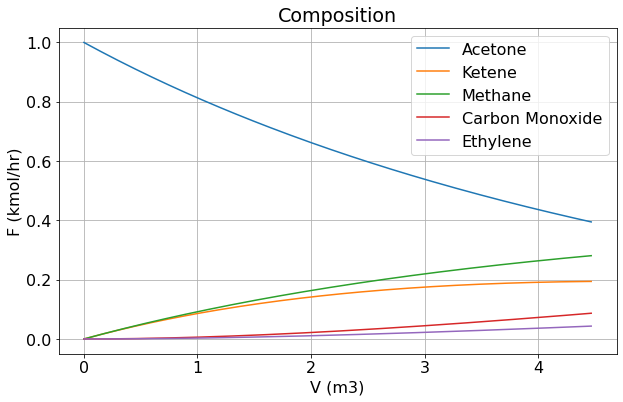

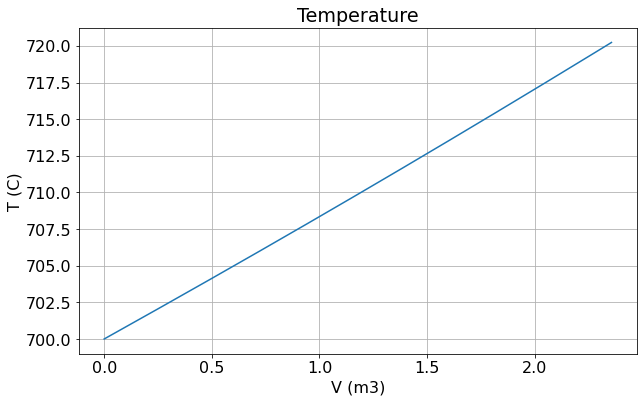

In [12]:
run_model(120, 19650)

